In [5]:
!pip install -q kagglehub

In [6]:
import os
import time
import itertools
import pathlib
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import regularizers

In [7]:
import kagglehub

path = kagglehub.dataset_download(
    "tawsifurrahman/covid19-radiography-database"
)

print("Dataset root:", path)

Using Colab cache for faster access to the 'covid19-radiography-database' dataset.
Dataset root: /kaggle/input/covid19-radiography-database


In [8]:
data_dir = os.path.join(path, "COVID-19_Radiography_Dataset")
print(os.listdir(data_dir))

['Lung_Opacity.metadata.xlsx', 'Normal.metadata.xlsx', 'README.md.txt', 'COVID.metadata.xlsx', 'Normal', 'Lung_Opacity', 'Viral Pneumonia.metadata.xlsx', 'Viral Pneumonia', 'COVID']


In [9]:
def define_paths(data_dir):
    filepaths = []
    labels = []

    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        for sub in os.listdir(class_path):
            if sub.lower() == "masks":
                continue

            sub_path = os.path.join(class_path, sub)

            if os.path.isdir(sub_path):
                for img in os.listdir(sub_path):
                    filepaths.append(os.path.join(sub_path, img))
                    labels.append(class_name)
            else:
                filepaths.append(sub_path)
                labels.append(class_name)

    return filepaths, labels

In [10]:
def define_df(files, labels):
    return pd.DataFrame({
        "filepaths": files,
        "labels": labels
    })

In [11]:
def split_data(data_dir):
    files, labels = define_paths(data_dir)
    df = define_df(files, labels)

    train_df, temp_df = train_test_split(
        df, train_size=0.8, stratify=df["labels"], random_state=123
    )

    val_df, test_df = train_test_split(
        temp_df, train_size=0.5, stratify=temp_df["labels"], random_state=123
    )

    return train_df, val_df, test_df

In [12]:
train_df, val_df, test_df = split_data(data_dir)

print(len(train_df), len(val_df), len(test_df))

16932 2116 2117


In [13]:
def create_gens(train_df, val_df, test_df, batch_size):
    img_size = (224, 224)

    train_gen = ImageDataGenerator(horizontal_flip=True)
    valid_gen = ImageDataGenerator()
    test_gen  = ImageDataGenerator()

    train = train_gen.flow_from_dataframe(
        train_df,
        x_col="filepaths",
        y_col="labels",
        target_size=img_size,
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=True
    )

    val = valid_gen.flow_from_dataframe(
        val_df,
        x_col="filepaths",
        y_col="labels",
        target_size=img_size,
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=True
    )

    test = test_gen.flow_from_dataframe(
        test_df,
        x_col="filepaths",
        y_col="labels",
        target_size=img_size,
        class_mode="categorical",
        batch_size=batch_size,
        shuffle=False
    )

    return train, val, test

In [14]:
train_gen, val_gen, test_gen = create_gens(
    train_df, val_df, test_df, batch_size=16
)

Found 16932 validated image filenames belonging to 4 classes.
Found 2116 validated image filenames belonging to 4 classes.
Found 2117 validated image filenames belonging to 4 classes.


In [15]:
class_count = len(train_gen.class_indices)
print("Classes:", train_gen.class_indices)

Classes: {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}


In [34]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3),
    pooling="max"
)

base_model.trainable = False

In [35]:
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(
        256,
        activation="relu",
        kernel_regularizer=regularizers.l2(0.016),
        activity_regularizer=regularizers.l1(0.006),
        bias_regularizer=regularizers.l1(0.006)
    ),
    Dropout(0.45),
    Dense(class_count, activation="softmax")
])

In [36]:
model.compile(
    optimizer=Adamax(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,655 (16.72 MB)

 Trainable params: 331,524 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [37]:
EPOCHS = 15

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)

Epoch 1/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 133s 103ms/step - accuracy: 0.6267 - loss: 9.2697 - val_accuracy: 0.7448 - val_loss: 2.0435
Epoch 2/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 81s 76ms/step - accuracy: 0.6946 - loss: 1.6680 - val_accuracy: 0.8039 - val_loss: 0.9452
Epoch 3/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 80s 75ms/step - accuracy: 0.7267 - loss: 1.0150 - val_accuracy: 0.8199 - val_loss: 0.8049
Epoch 4/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 81s 77ms/step - accuracy: 0.7524 - loss: 0.9151 - val_accuracy: 0.8455 - val_loss: 0.7462
Epoch 5/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 81s 77ms/step - accuracy: 0.7565 - loss: 0.8829 - val_accuracy: 0.8393 - val_loss: 0.7070
Epoch 6/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 80s 76ms/step - accuracy: 0.7544 - loss: 0.8531 - val_accuracy: 0.8370 - val_loss: 0.6973
Epoch 7/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 81s 76ms/step - accuracy: 0.7626 - loss: 0.8277 - val_accuracy: 0.8455 - val_loss: 0.6723
Epoch 8/15
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 80s 75ms/step - accuracy: 0.7590

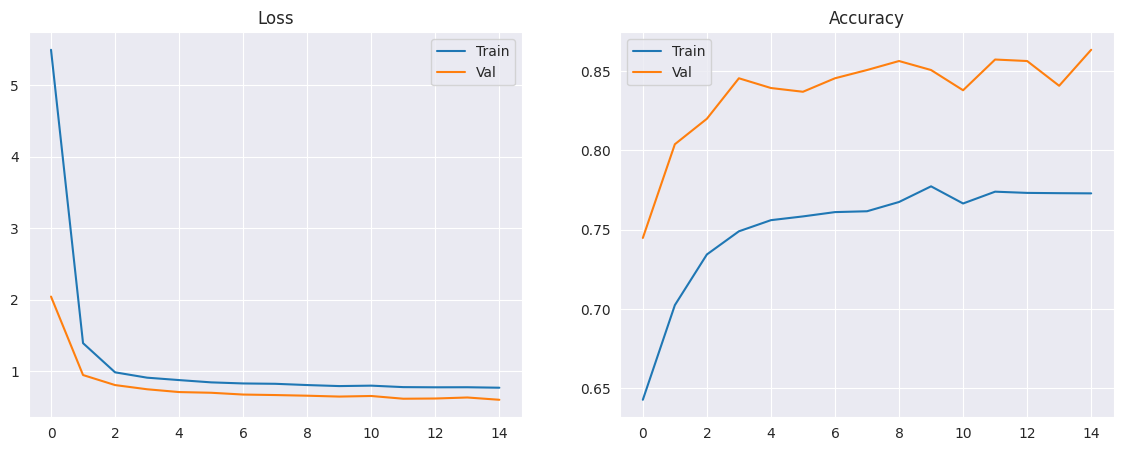

In [38]:
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.show()


In [39]:
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)

133/133 ━━━━━━━━━━━━━━━━━━━━ 13s 101ms/step - accuracy: 0.8811 - loss: 0.5795
Test Accuracy: 0.8814359903335571


In [40]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

133/133 ━━━━━━━━━━━━━━━━━━━━ 22s 110ms/step


In [41]:
cm = confusion_matrix(test_gen.classes, y_pred)
classes = list(test_gen.class_indices.keys())

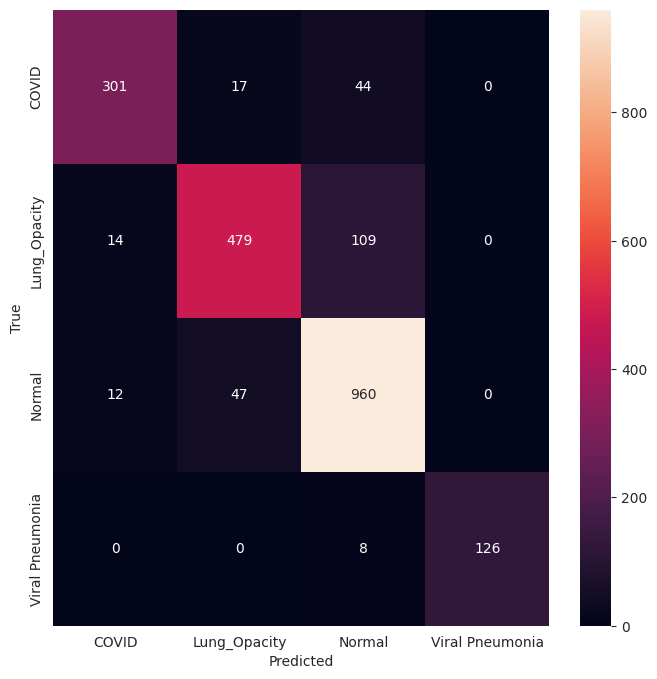

In [42]:
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [43]:
print(classification_report(
    test_gen.classes,
    y_pred,
    target_names=classes
))

                 precision    recall  f1-score   support

          COVID       0.92      0.83      0.87       362
   Lung_Opacity       0.88      0.80      0.84       602
         Normal       0.86      0.94      0.90      1019
Viral Pneumonia       1.00      0.94      0.97       134

       accuracy                           0.88      2117
      macro avg       0.91      0.88      0.89      2117
   weighted avg       0.88      0.88      0.88      2117



In [26]:
model.save("covid_efficientnetb0.h5")
print("Model saved")

Model saved
